# Performing sentiment analysis on tips

In [2]:
from google.cloud import bigquery
import pandas as pd
import nltk

## Initialise connection to Big Query

* requires a key to service account json key in order to access BQ

In [3]:
PROJECT_ID = "yelp-data-warehouse"
DATASET_ID = "yelp_dataset"
TIPS_TABLE_ID = "yelp_tips"

GOOGLE_APPLICATION_CREDENTIALS = 'path/to/service/key/json'

client = bigquery.Client.from_service_account_json(GOOGLE_APPLICATION_CREDENTIALS,project = PROJECT_ID)

#### Tips table attributes: 
* 'tips_id'
* 'text'
* 'names' (business name), 
* 'business_id'
* 'user_id'
* 'compliment_count'

## NLP is performed using NLTK's pre-trained sentiment analyser, tokenizer and lemmatizer

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Make a list of english stopwords
stopwords = nltk.corpus.stopwords.words("english")

# Tokenizer can remove duplicate words
regexp = RegexpTokenizer('\w+')

analyzer = SentimentIntensityAnalyzer()

wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

## Given a business id, 
* output the sentiment score for each of the tips tied to this business. 
* Display a word cloud for the most common words found across all the tips

In [6]:
def analyse_by_biz(business_id):
    query = f"SELECT * FROM {DATASET_ID}.{TIPS_TABLE_ID} WHERE business_id = '{business_id}'"

    result_df = client.query(query).to_dataframe()
    result_df['text'] = result_df['text'].str.lower()

    # Tokenisation, remove any duplicates '\w+'
    result_df['text_token'] = result_df['text'].apply(regexp.tokenize)
    
    # remove stop words, numbers
    result_df['text_token'] = result_df['text_token'].apply(lambda x: [item for item in x if item not in stopwords and not item.isnumeric()]) 

    # lemmatize
    result_df['text_lem'] = result_df['text_token'].apply(lambda x: [wordnet_lemmatizer.lemmatize(item) for item in x])
    result_df['text_lem'] = result_df['text_lem'].apply(lambda x : " ".join(x))
    

    # Plot word cloud
    combined_lem = ' '.join([word for word in result_df['text_lem']])
    wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(combined_lem)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    # sentiment score
    result_df['polarity'] = result_df['text_lem'].apply(lambda x: analyzer.polarity_scores(x))

    # change dataframe
    result_df = pd.concat(
        [result_df, 
         result_df['polarity'].apply(pd.Series)], axis=1)
    
    result_df['sentiment'] = result_df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
    
    print(result_df['sentiment'].value_counts())
    return result_df.head(10)

neutral     13
positive    13
negative     3
Name: sentiment, dtype: int64


,names,date,text,tips_id,compliment_count,business_id,user_id,text_token,text_lem,polarity,neg,neu,pos,compound,sentiment
0,MKT,2013-08-22 23:14:14+00:00,$4 beer on thursday!!,bc64add67ab3ae375a441a7bde7c7f7cc3c6635db54e96...,0,sPxAZRMzMsvwO2e8impPBA,o_KK0tgEOiSROXIWIBxXMw,"[beer, thursday]",beer thursday,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral
1,MKT,2015-07-03 03:23:47+00:00,can't beat 4-5 free pour thursday's. love the ...,396d036c44bbd989571c160714094406425a42837e40bf...,0,sPxAZRMzMsvwO2e8impPBA,UZPycrVJ2eOXfcuYC0D4cQ,"[beat, free, pour, thursday, love, beer, float...",beat free pour thursday love beer float pretze...,"{'neg': 0.0, 'neu': 0.483, 'pos': 0.517, 'comp...",0.000,0.483,0.517,0.8176,positive
2,MKT,2013-03-17 22:33:26+00:00,st paddys $4 magners!!!,6b72560917c00f5a3729597d091fd820bd85569088687b...,0,sPxAZRMzMsvwO2e8impPBA,EIpPME2cIuNbhfXrtsSApg,"[st, paddys, magners]",st paddy magners,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral
3,MKT,2017-07-31 23:21:10+00:00,nothing can beat the $2.50 tap beers on thrusd...,8a552fdb736b0b632d83a1076ea201387d823aef35fe91...,0,sPxAZRMzMsvwO2e8impPBA,JGFD2fYfiTVtUeMXlWPDKg,"[nothing, beat, tap, beers, thrusdays]",nothing beat tap beer thrusdays,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral
4,MKT,2014-08-15 01:50:33+00:00,"no change tables for babies, but they are allo...",7eb9f08ebdc5b1db89d93300bc5d8413363953da766a26...,0,sPxAZRMzMsvwO2e8impPBA,Q5jOFJYhIsN8ouJ1rnsLQQ,"[change, tables, babies, allowed, 9pm]",change table baby allowed 9pm,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral
5,MKT,2016-05-01 01:47:58+00:00,"worst bar in edmonton. seat yourself, unfriend...",f8c727f6036633bf78602e7a07de09e6eae32ccdd9f5b3...,0,sPxAZRMzMsvwO2e8impPBA,uGCgFLBIsxp4jjhPOcKQnA,"[worst, bar, edmonton, seat, unfriendly, serve...",worst bar edmonton seat unfriendly server staf...,"{'neg': 0.655, 'neu': 0.345, 'pos': 0.0, 'comp...",0.655,0.345,0.000,-0.8591,negative
6,MKT,2016-03-10 20:59:18+00:00,thursday beers on tap used to be $4 for anythi...,9cb44c581e2b09738a29b7595c73af23df547414a136ca...,0,sPxAZRMzMsvwO2e8impPBA,2feiZFzICp_mLONEpzY0pA,"[thursday, beers, tap, used, anything, changed...",thursday beer tap used anything changed good l...,"{'neg': 0.0, 'neu': 0.791, 'pos': 0.209, 'comp...",0.000,0.791,0.209,0.4404,positive
7,MKT,2013-08-12 07:00:56+00:00,60 beer taps. enough said!,38cddad8b6c4921988dcf6eed5b02ceb80b5201d3bc065...,0,sPxAZRMzMsvwO2e8impPBA,2feiZFzICp_mLONEpzY0pA,"[beer, taps, enough, said]",beer tap enough said,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral
8,MKT,2013-03-20 04:09:16+00:00,my full-sized mkt house salad (with pecans and...,39e2f72e66debf012a0e6073688131be8f88fb4465ac3a...,0,sPxAZRMzMsvwO2e8impPBA,LYiWKAEhRSOVxULXfRraGQ,"[full, sized, mkt, house, salad, pecans, slice...",full sized mkt house salad pecan sliced apple ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral
9,MKT,2017-10-22 22:35:49+00:00,the new menu looks wicked! i would recommend a...,6c42085de91fe1497eda85ec56693281311c7453eb2ac1...,0,sPxAZRMzMsvwO2e8impPBA,wgkjjTkyLPXBq_JW3N-Zkw,"[new, menu, looks, wicked, would, recommend, a...",new menu look wicked would recommend avoiding ...,"{'neg': 0.302, 'neu': 0.469, 'pos': 0.229, 'co...",0.302,0.469,0.229,-0.3400,negative


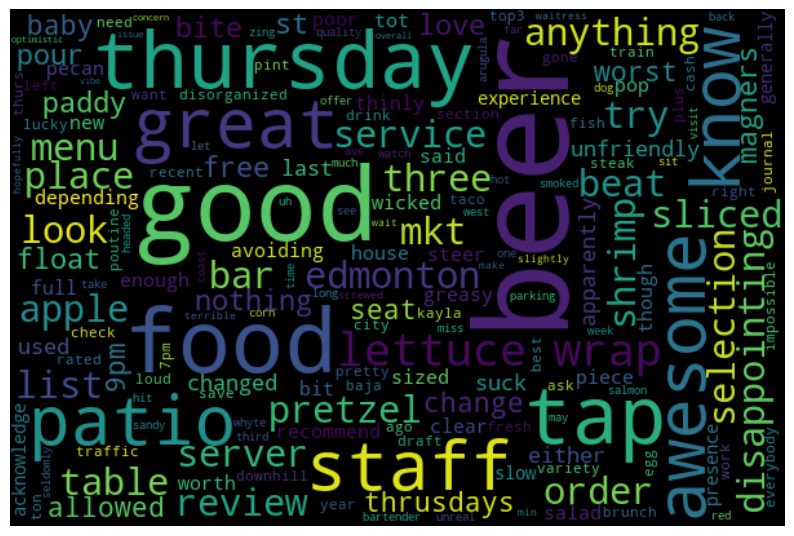

In [7]:
test_id = '-6kIZWnXPuDC6JiQJ-A1fg'
test_id_2 = 'sPxAZRMzMsvwO2e8impPBA'
    
analyse_by_biz(test_id_2)

This implementation is one of many applications of sentiment analysis and NLP. Using pre-trained models, this method can help business score the sentiment of their tips, and determine what customers would talk about. This can enable businesses to better understand their customer's concerns. Besides looking at stars, the sentiment score can help pinpoint strong feedbacks as well.